In [1]:
import os
import numpy as np
import zipfile
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.python.keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Define the training and validation base directories
train_dir = '/content/drive/MyDrive/Bangkit/Final_Dataset/train'
val_dir = '/content/drive/MyDrive/Bangkit/Final_Dataset/val'
labels = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
print(labels)

['ayam_goreng', 'ayam_pop', 'gulai_ikan', 'telur_balado', 'telur_dadar', 'anggur', 'apel', 'cherry', 'jeruk', 'kiwi', 'mangga', 'pisang', 'sawo', 'strawberi', 'burger', 'sate', 'nasi_padang', 'bakso', 'nasi_goreng', 'ayam_betutu', 'batagor', 'cireng', 'coto_makassar', 'gudeg', 'kerak_telor', 'mie_aceh', 'nasi_kuning', 'nasi_pecel', 'pempek', 'rawon', 'rendang', 'serabi', 'tahu_sumedang', 'soto', 'dendeng']


In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Instantiate the ImageDataGenerator class
    # normalize pixel values and set arguments to augment the images
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        brightness_range=[0.7, 1.3],
                                        fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    testing_datagen = ImageDataGenerator(rescale = 1.0/255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = validation_datagen.flow_from_directory(directory='/content/drive/MyDrive/Bangkit/Final_Dataset/test',
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    return train_generator, validation_generator, testing_generator

In [11]:
# Test generators
train_generator, validation_generator, testing_generator = train_val_generators(train_dir, val_dir, '/content/drive/MyDrive/Bangkit/Final_Dataset/test')

Found 2074 images belonging to 35 classes.
Found 248 images belonging to 35 classes.
Found 279 images belonging to 35 classes.


In [ ]:
# Import the inception model
from tensorflow.keras.applications import MobileNetV2

In [ ]:
pre_trained_model = MobileNetV2(input_shape = (224, 224, 3),
                                  include_top = False,
                                  weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Print the model summary
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,257,984 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
output = pre_trained_model.output
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")


The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [ ]:
def create_final_model(pre_trained_model):
    output = pre_trained_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(output)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    predictions = tf.keras.layers.Dense(35, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Save model in a variable
model = create_final_model(pre_trained_model)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 4,953,187 total parameters in this model.
There are 2,695,203 trainable parameters in this model.


In [ ]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('val_accuracy') > 0.91 and logs.get('accuracy') > 0.91):
                print("\n Stop Training because accuracy is more than 90.0%")
                self.model.stop_training = True

customcallback = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 1,
                    callbacks = [customcallback])

Epoch 1/50
65/65 [==============================] - 1040s 16s/step - loss: 1.9956 - accuracy: 0.4735 - val_loss: 0.8031 - val_accuracy: 0.7258
Epoch 2/50
65/65 [==============================] - 53s 813ms/step - loss: 0.9936 - accuracy: 0.7102 - val_loss: 0.6654 - val_accuracy: 0.7661
Epoch 3/50
65/65 [==============================] - 50s 767ms/step - loss: 0.7305 - accuracy: 0.7710 - val_loss: 0.5063 - val_accuracy: 0.8427
Epoch 4/50
65/65 [==============================] - 51s 783ms/step - loss: 0.6433 - accuracy: 0.7898 - val_loss: 0.4229 - val_accuracy: 0.8548
Epoch 5/50
65/65 [==============================] - 53s 810ms/step - loss: 0.5720 - accuracy: 0.8115 - val_loss: 0.4747 - val_accuracy: 0.8548
Epoch 6/50
65/65 [==============================] - 49s 758ms/step - loss: 0.5157 - accuracy: 0.8264 - val_loss: 0.5306 - val_accuracy: 0.8306
Epoch 7/50
65/65 [==============================] - 51s 789ms/step - loss: 0.5015 - accuracy: 0.8351 - val_loss: 0.4294 - val_accuracy: 0.8548

In [ ]:
import pandas as pd

# Assuming 'history' is the dictionary containing training history
hist_df = pd.DataFrame(history.history)

# Save to JSON
hist_df.to_json('/content/drive/MyDrive/Bangkit/Final_Dataset/History/history_mobilenetv2_valacc_0.9194.json')

# Or save to CSV
hist_df.to_csv('/content/drive/MyDrive/Bangkit/Final_Dataset/History/history_mobilenetv2_valacc_0.9194.csv')

In [ ]:
import pandas as pd

data = '/content/drive/MyDrive/Bangkit/Final_Dataset/History/history_mobilenetv2_valacc_0.9194.csv'
dataset = pd.read_csv(data)
dataset.head()

Unnamed: 0      loss  accuracy  val_loss  val_accuracy
0           0  1.995588  0.473481  0.803089      0.725806
1           1  0.993591  0.710222  0.665367      0.766129
2           2  0.730455  0.770974  0.506279      0.842742
3           3  0.643286  0.789778  0.422925      0.854839
4           4  0.572021  0.811475  0.474659      0.854839

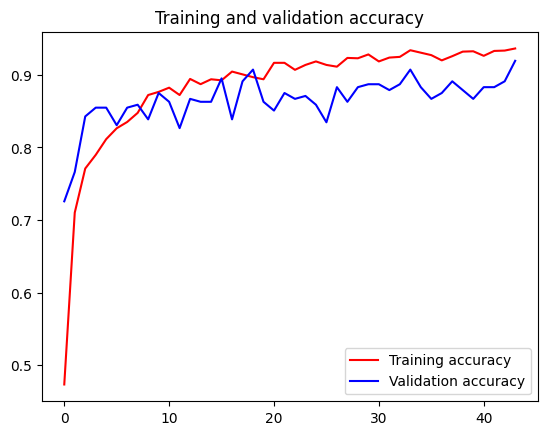

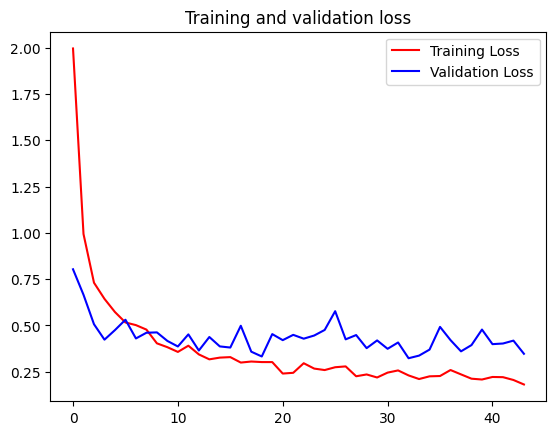

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = dataset['accuracy']
val_acc = dataset['val_accuracy']
loss = dataset['loss']
val_loss = dataset['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pickle

# Assuming 'history' is the dictionary containing training history
with open('/content/drive/MyDrive/Dataset_Final/trainHistoryDict.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
with open('/content/drive/MyDrive/Dataset_Final/trainHistoryDict.pkl', 'rb') as file:
    loaded_history = pickle.load(file)


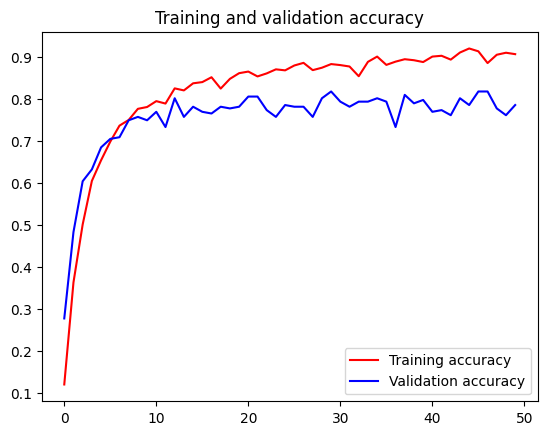

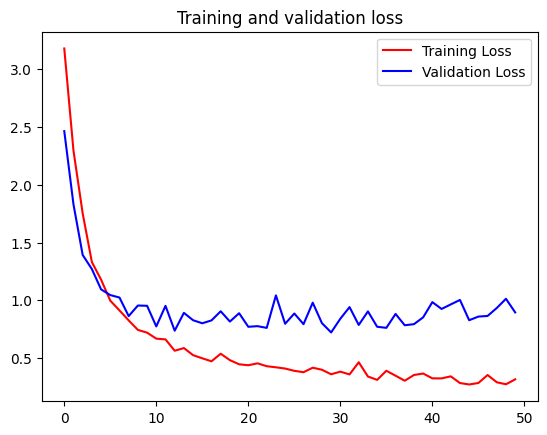

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import tensorflow as tf
from keras.models import load_model

# Memuat model dari file H5
model = load_model('/content/drive/MyDrive/Dataset_Final/model_1.h5')

In [ ]:
!pip list

1/1 [==============================] - 1s 756ms/step


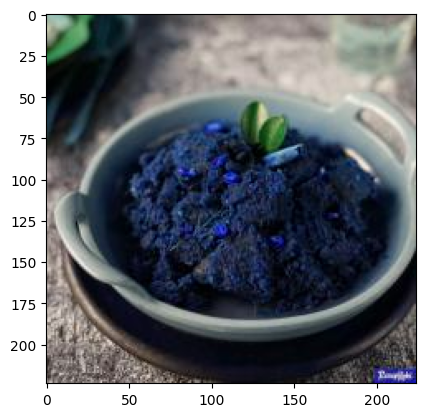

Image Rendang-34_jpg.rf.4b05edd32e60c39063250b70ce871ba6.jpg: Predicted class: coto_makassar, Accuracy: 98.71%
1/1 [==============================] - 0s 23ms/step


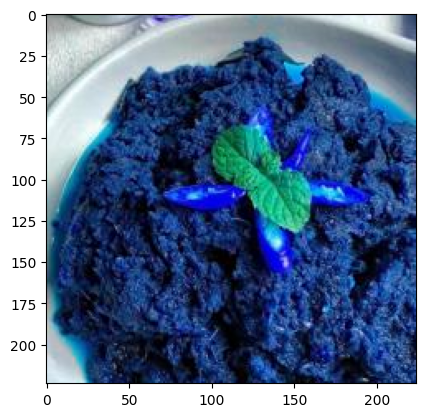

Image Rendang-36_jpg.rf.b72fd136cf9dd524618195bf226390be.jpg: Predicted class: rendang, Accuracy: 98.57%
1/1 [==============================] - 0s 32ms/step


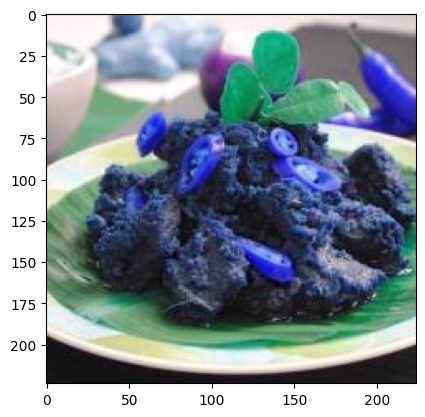

Image Rendang-42_jpg.rf.aa57dff3a1f395b10e0fa7403352ed56.jpg: Predicted class: coto_makassar, Accuracy: 53.06%
1/1 [==============================] - 0s 44ms/step


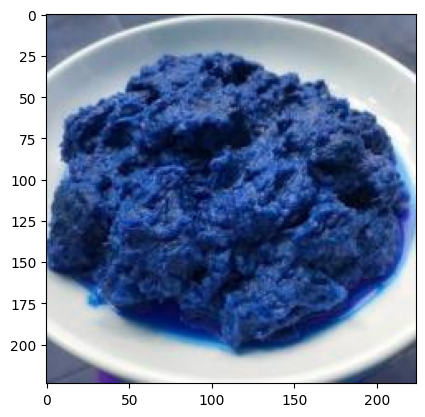

Image Rendang-31_jpg.rf.094adcd940ed1d80307f778ec3c3dd23.jpg: Predicted class: rendang, Accuracy: 99.93%
1/1 [==============================] - 0s 30ms/step


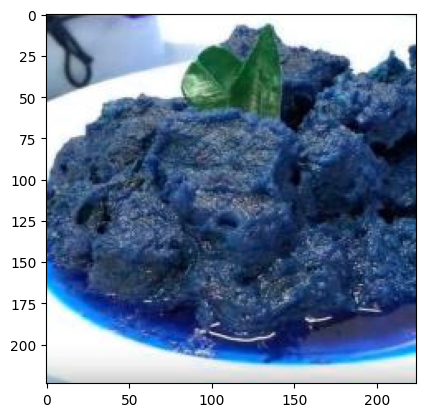

Image Rendang-30_jpg.rf.1c51bfb5497d09ae47004cddc956e16a.jpg: Predicted class: rendang, Accuracy: 99.72%
1/1 [==============================] - 0s 34ms/step


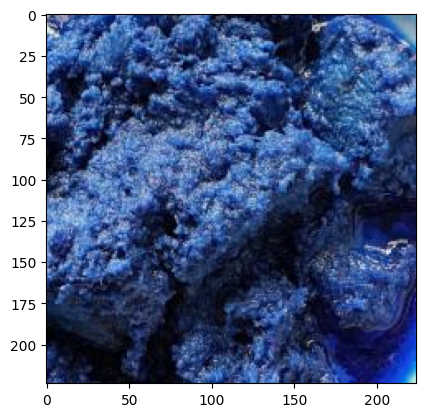

Image Rendang-17_jpg.rf.c28527b145ebccab51af50140e418bb1.jpg: Predicted class: rendang, Accuracy: 98.32%
1/1 [==============================] - 0s 145ms/step


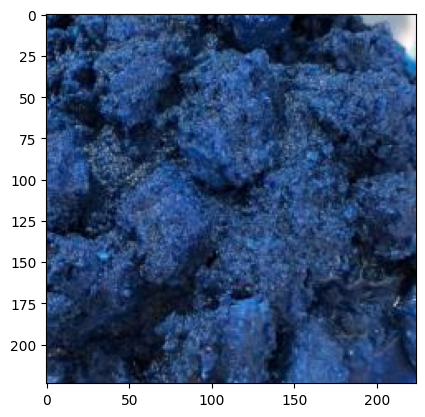

Image Rendang-18_jpg.rf.8ac53217c4453efcdacd46d5fe6d9812.jpg: Predicted class: kerak_telor, Accuracy: 94.92%
1/1 [==============================] - 0s 23ms/step


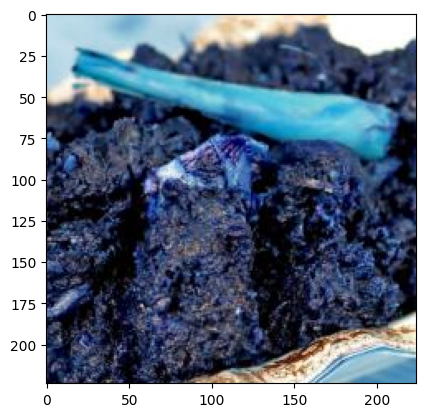

Image Rendang-16_jpg.rf.da272330caf5ac679eea326173e74f6f.jpg: Predicted class: rendang, Accuracy: 48.66%
1/1 [==============================] - 0s 27ms/step


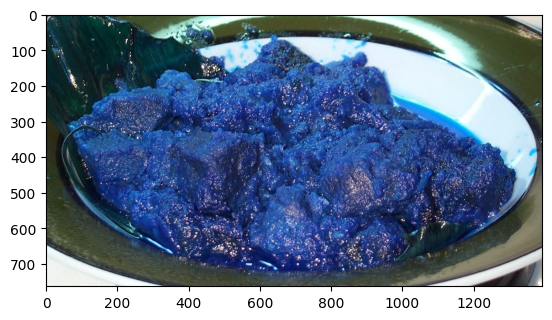

Image daging_rendang (1).jpg: Predicted class: rendang, Accuracy: 100.00%
1/1 [==============================] - 0s 22ms/step


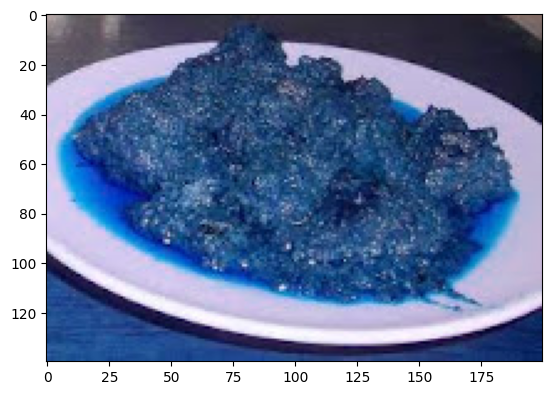

Image daging_rendang (102).jpg: Predicted class: rendang, Accuracy: 97.59%
1/1 [==============================] - 0s 21ms/step


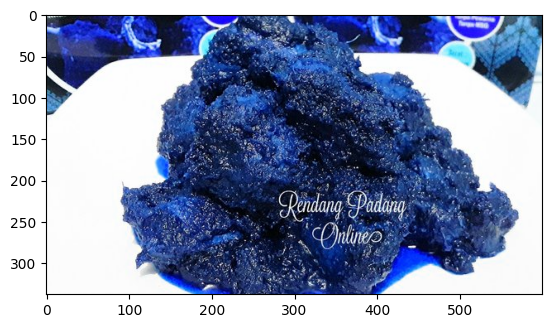

Image daging_rendang (106).jpg: Predicted class: rendang, Accuracy: 94.79%
1/1 [==============================] - 0s 22ms/step


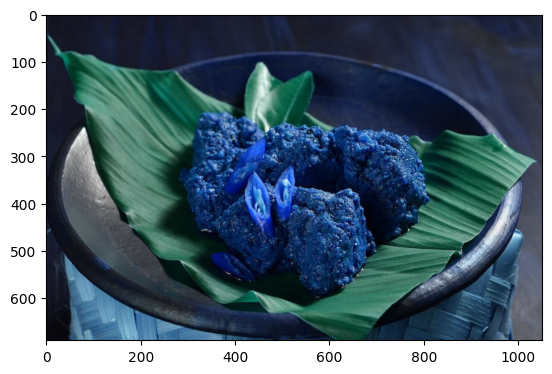

Image daging_rendang (17).jpg: Predicted class: rendang, Accuracy: 98.30%
1/1 [==============================] - 0s 22ms/step


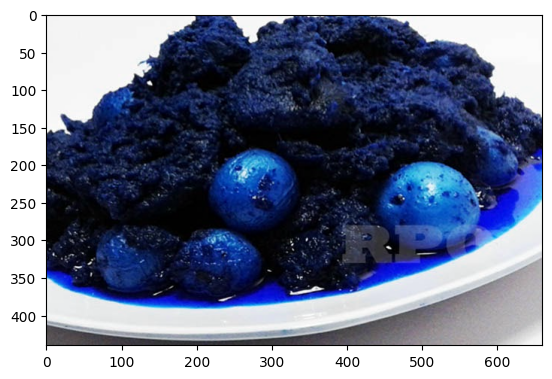

Image daging_rendang (100).jpg: Predicted class: rendang, Accuracy: 99.16%
1/1 [==============================] - 0s 31ms/step


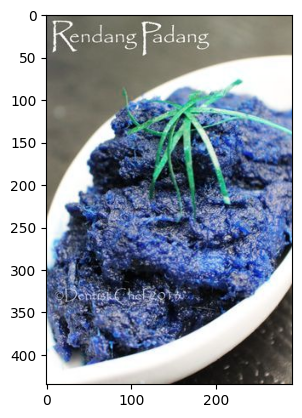

Image daging_rendang (52).jpg: Predicted class: rendang, Accuracy: 99.85%
1/1 [==============================] - 0s 22ms/step


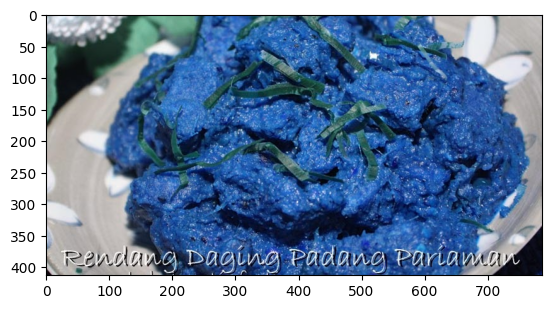

Image daging_rendang (71).jpg: Predicted class: rendang, Accuracy: 64.10%
1/1 [==============================] - 0s 94ms/step


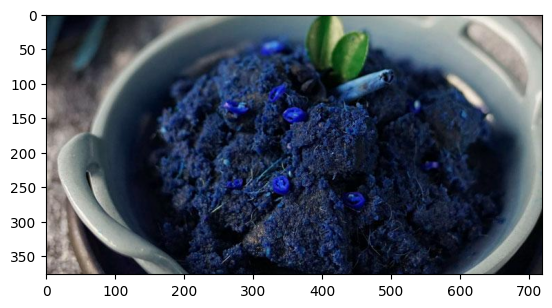

Image daging_rendang (80).jpg: Predicted class: rendang, Accuracy: 99.77%
1/1 [==============================] - 0s 34ms/step


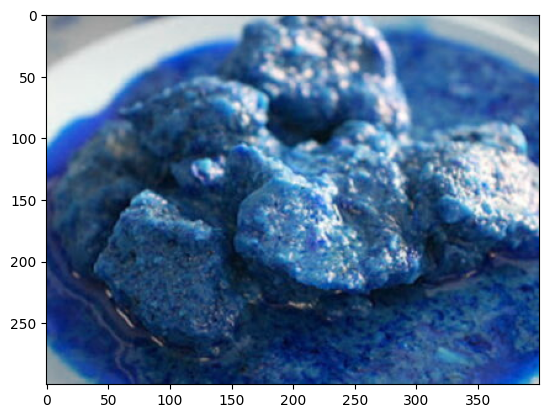

Image daging_rendang (98).jpg: Predicted class: rendang, Accuracy: 100.00%


In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model (replace 'model_path' with the actual path to your saved model)
model = tf.keras.models.load_model('/content/drive/MyDrive/Bangkit/Final_Dataset/Model/model_mobile_valacc_0.9032.h5')

# Path to the folder containing images for prediction
folder_path = "/content/drive/MyDrive/Bangkit/Final_Dataset/test/rendang"

# Loop through each image in the folder
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, filename))
    # Resize the image to match the input size of your model
    resize = tf.image.resize(img, (224, 224))
    # Normalize pixel values to [0, 1]
    input_data = np.expand_dims(resize / 255, 0)
    # Make predictions
    predictions = model.predict(input_data)
    plt.imshow(img)
    plt.show()
    # Assuming your model outputs class probabilities, you can get the predicted class index
    class_names = list(train_generator.class_indices.keys())
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    predicted_probability = np.max(predictions) * 100
    print(f"Image {filename}: Predicted class: {predicted_class_name}, Accuracy: {predicted_probability:.2f}%")

9/9 [==============================] - 4s 313ms/step - loss: 0.5251 - accuracy: 0.8710
[0.5250751972198486, 0.8709677457809448]
9/9 [==============================] - 4s 352ms/step
Length of predictions: 279
Length of true labels: 279


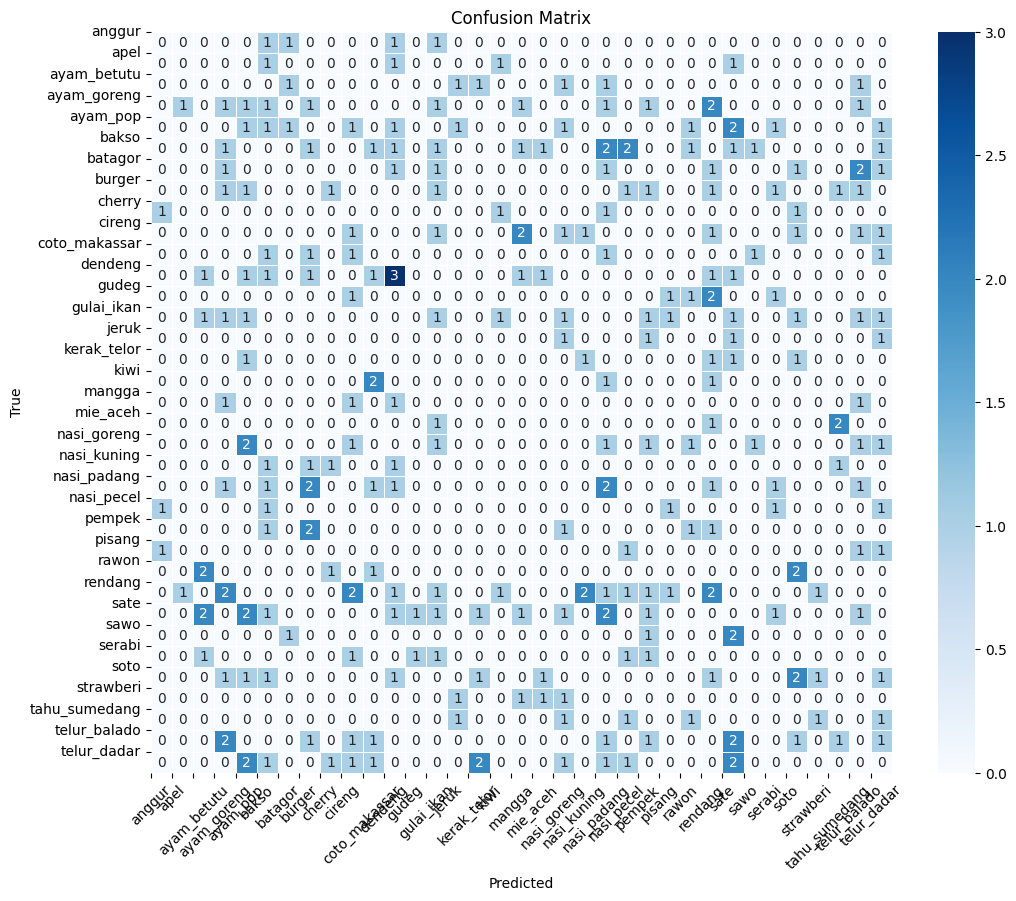

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Bangkit/Final_Dataset/Model/model_mobile_valacc_0.9194.h5')

print(model.evaluate(testing_generator))

# Assuming `testing_generator` is defined and you have predictions
# If not already done, generate predictions using the model
predictions = model.predict(testing_generator)

# Ensure predictions are in the correct format
y_pred_class = np.argmax(predictions, axis=1)

# Get true labels
y_true_class = testing_generator.classes

# Check lengths of predictions and true labels
print(f'Length of predictions: {len(y_pred_class)}')
print(f'Length of true labels: {len(y_true_class)}')

# Ensure they have the same length
assert len(y_pred_class) == len(y_true_class), "Mismatch in number of samples between predictions and true labels"

# Define class names
nama_kelas = ['anggur', 'apel', 'ayam_betutu', 'ayam_goreng', 'ayam_pop', 'bakso', 'batagor', 'burger', 'cherry', 'cireng', 'coto_makassar', 'dendeng', 'gudeg', 'gulai_ikan', 'jeruk', 'kerak_telor', 'kiwi', 'mangga', 'mie_aceh', 'nasi_goreng', 'nasi_kuning', 'nasi_padang', 'nasi_pecel', 'pempek', 'pisang', 'rawon', 'rendang', 'sate', 'sawo', 'serabi', 'soto', 'strawberi', 'tahu_sumedang', 'telur_balado', 'telur_dadar']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
fig.tight_layout(h_pad=2)
sns.heatmap(
    confusion_matrix(y_true_class, y_pred_class),
    annot=True,
    annot_kws={"fontsize": 10},
    fmt=".0f",
    linewidth=0.5,
    square=True,
    cmap='Blues'
)
plt.xticks(range(len(nama_kelas)), nama_kelas, rotation=45)
plt.yticks(range(len(nama_kelas)), nama_kelas, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Bangkit/Final_Dataset/Model/model_mobile_valacc_0.9194_2.h5')

In [ ]:
new_model = keras.models.load_model

In [ ]:
model.save_weights("/content/drive/MyDrive/Bangkit/Final_Dataset/Model/model_mobile_valacc_0.9194_weights.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/Bangkit/Final_Dataset/Model/model_mobile_valacc_0.9194_weights.h5")

In [ ]:
json_string = model.to_json()

with open("model_mobile_valacc_0.9194", "w") as f:
  f.write(json_string)

In [ ]:
tf.saved_model.save(model, 'saved_model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'model_mobile_valacc_0.9194_2.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)